In [1]:
# Dependency imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load the Stokes boundary layer data

In [2]:
# Data loading function

def load_data():
    my_train_path = "kaggle_train_Stokes.csv"
    my_benchmark_path = "kaggle_benchmark_Stokes.csv"
    return {"train": pd.read_csv(my_train_path), "secret_test": pd.read_csv(my_benchmark_path)}

In [3]:
# Load train and test dataframes from file.

data = load_data()
data["train"].head()

,id,h,omega,nu,U,u*,z*
0,0,714.848180,3.270814e-07,0.010348,3.936251,4.373923,714.848180
1,1,37.759470,5.967479e-04,0.028270,51.694711,55.009575,22.985011
2,2,4793.296822,5.002740e-11,0.000055,228.857112,246.913461,3986.903017
3,3,252.695524,2.312996e-05,0.016444,54.805944,58.478971,88.865519
4,4,5.221472,1.675826e-03,0.002551,33.446634,36.757917,5.221472


In [4]:
# Split the data between a 80%-20% train-test split

df = data["train"]

train_df = df.sample(frac=0.8, random_state=42)
test_df  = df.drop(train_df.index)

# Reorder the two dataframes by id

train_df = train_df.sort_values(by="id").reset_index(drop=True)
test_df = test_df.sort_values(by="id").reset_index(drop=True)

print("Full df:", df.shape)
print("Train df:", train_df.shape)
print("Test df:", test_df.shape)
train_df.head()

Full df: (9000, 7)
Train df: (7200, 7)
Test df: (1800, 7)


,id,h,omega,nu,U,u*,z*
0,0,714.848180,3.270814e-07,0.010348,3.936251,4.373923,714.848180
1,1,37.759470,5.967479e-04,0.028270,51.694711,55.009575,22.985011
2,3,252.695524,2.312996e-05,0.016444,54.805944,58.478971,88.865519
3,6,6569.666464,5.374064e-08,0.056985,345.959808,368.742373,3414.281551
4,7,352.888235,9.913135e-07,0.003831,347.131460,369.412480,206.622097


## Building blocks for neural networks

In [5]:
# Create the homogeneous coordinates for the training data

id=[]
x1=[]
x2=[]
z=[]

for i in range(len(train_df.id)):
    id.append(train_df.id[i])
    x1.append(train_df.nu[i]/(train_df.h[i]*train_df.omega[i]))
    x2.append(np.sqrt(train_df.nu[i]/train_df.omega[i]))
    z.append(train_df["z*"][i])

data_hom = pd.DataFrame({
    "id": id,
    "x1": x1,
    "x2": x2,
    "z": z
})
data_hom.head()

,id,x1,x2,z
0,0,44.257661,177.869358,714.848180
1,1,1.254613,6.882844,22.985011
2,3,2.813362,26.663155,88.865519
3,6,161.402623,1029.738510,3414.281551
4,7,10.952667,62.169666,206.622097


In [6]:
# Scale the homogeneous coordinates by z

data_hom_scaled=data_hom.div(data_hom.z, axis=0)
data_hom_scaled.id=data_hom_scaled.id*data_hom.z
data_hom_scaled.id=data_hom_scaled.id.astype(int)
data_hom_scaled.head()

,id,x1,x2,z
0,0,0.061912,0.248821,1.0
1,1,0.054584,0.299449,1.0
2,3,0.031659,0.300039,1.0
3,6,0.047273,0.301597,1.0
4,6,0.053008,0.300886,1.0


In [7]:
print(data_hom_scaled.shape)

(7200, 4)


Text(0, 0.5, 'x2')

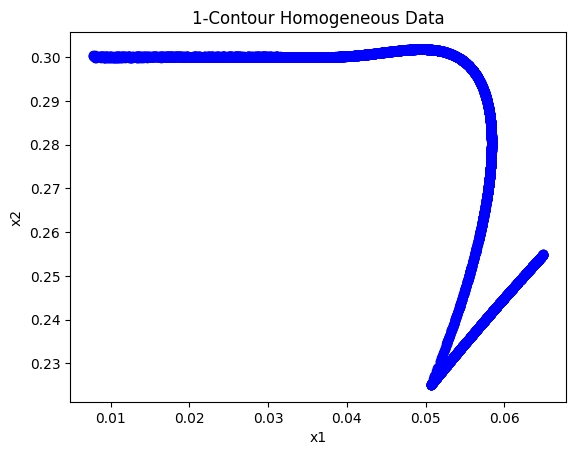

In [8]:
# Plot the homogeneous coordinates

plt.plot(data_hom_scaled.x1, data_hom_scaled.x2, "ob")
plt.title("1-Contour Homogeneous Data")
plt.xlabel("x1")
plt.ylabel("x2")

In [9]:
# Network weight initialization function
# Check the assignment text for a different way to initialize your weights.
# We might want to consider values for the learning rate µ ∈ [10−4, 10−2]!!

def init_weights(input_dim, output_dim):
    return np.random.uniform(-1.0, 1.0, (input_dim, output_dim))

In [10]:
# Activation functions

def relu(input):
    return np.maximum(0, input)

In [11]:
# Loss functions

def msre(input, target):
    return np.square((target - input) / target).mean()

In [12]:
# Predict using a trained set of model weights.

def predict(input, weights):
    [w1, w2] = weights
    return relu(input @ w1) @ w2

In [13]:
# Function to train a simple 2-N-1 model.
# NOTE: This function expects numpy matrices for the train and test data.
#       If your train and test data is stored in pandas dataframes you 
#       can convert using the `.to_numpy()` function.

def train_model(num_neurons, epochs, train, test, lr = 5e-5):
    w1 = init_weights(2, num_neurons)
    w2 = init_weights(num_neurons, 1)

    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        epoch_loss = 0
            
        for entry in train:
            # Split the label from the input
            [x0, y] = np.split(entry, [-1], axis=1)

            # Forward pass
            z1 = x0 @ w1
            x1 = relu(z1)

            z2 = x1 @ w2

            # Compute error
            loss = msre(z2, y)
            epoch_loss += loss

            # TODO: Implement backward pass.

        #TODO: Compute total loss for the epoch
        loss_this_epoch = np.nan # Replace nan with your code
        # Add the loss for this epoch to the list of losses
        train_loss.append(loss_this_epoch)
        
        # Compute and store test loss.
        pred = predict(test[:, :2], [w1, w2])
        test_loss.append(msre(pred[:, 0], test[:, 2]))

    return [[train_loss, test_loss], [w1, w2]]

In [14]:
# Function to visualize the learned model behavior.

def plot_behavior(data, pred):
    # TODO: Plot the predicted one-contour/dimensionless relation vs the truth.

SyntaxError: incomplete input (2424859564.py, line 4)

In [ ]:
# TODO: Train your best neural network using sliders, grid search, or backpropagation. 
#       This network is allowed to have more than one intermediate layer.